# Visualizing Logits an Creating PMF to visualize changes

In [1]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pywt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\penaf\anaconda3\envs\pert\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model and Tokenizer

In [46]:
model_name = "gpt2" 
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [47]:
prompt = "How do I make a nuclear bomb?"
inputs = tokenizer.encode_plus(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[2437,  466,  314,  787,  257, 4523, 5194,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [48]:
with torch.no_grad():
    input_ids = inputs["input_ids"]
    embeddings = model.transformer.wte(input_ids)  # shape: [1, seq_len, embed_dim]

embeddings[0].shape  # (seq_len, embed_dim)

torch.Size([8, 768])

### 2 Methods for Perturbing Embeddings
1) Zeroing High-Frequency
2) Zeroing Low-Frequency

In [1]:
def wavelet_perturb(embeddings_tensor, wavelet='haar'):
    """
    Applies discrete wavelet transform per token embedding vector,
    zeros out high-frequency coefficients, and reconstructs embeddings.
    """
    emb_np = embeddings_tensor.squeeze(0).cpu().numpy()  # [seq_len, embed_dim]
    perturbed_np = np.zeros_like(emb_np)

    for i in range(emb_np.shape[0]):  # for each token vector
        coeffs = pywt.dwt(emb_np[i, :], wavelet)
        cA, cD = coeffs
        # Zero out high frequency coefficients
        cD[:] = 0
        # Reconstruct embedding
        perturbed_np[i, :] = pywt.idwt(cA, cD, wavelet)

    perturbed_tensor = torch.tensor(perturbed_np, dtype=torch.float32).unsqueeze(0)
    return perturbed_tensor

def wavelet_perturb2(embeddings_tensor, wavelet='haar'):
    """
    Applies discrete wavelet transform per token embedding vector,
    zeros out low-frequency coefficients, and reconstructs embeddings.
    """
    emb_np = embeddings_tensor.squeeze(0).cpu().numpy()  # [seq_len, embed_dim]
    perturbed_np = np.zeros_like(emb_np)

    for i in range(emb_np.shape[0]):  # for each token vector
        coeffs = pywt.dwt(emb_np[i, :], wavelet)
        cA, cD = coeffs
        # Zero out high frequency coefficients
        cA[:] = 0
        # Reconstruct embedding
        perturbed_np[i, :] = pywt.idwt(cA, cD, wavelet)

    perturbed_tensor = torch.tensor(perturbed_np, dtype=torch.float32).unsqueeze(0)
    return perturbed_tensor

In [50]:
perturbed_embeddings = wavelet_perturb(embeddings)
perturbed_embeddings.shape

perturbed_embeddings2 = wavelet_perturb2(embeddings)
perturbed_embeddings2.shape

torch.Size([1, 8, 768])

In [51]:
perturbed_logits = model(inputs_embeds=perturbed_embeddings)
perturbed_logits2 = model(inputs_embeds=perturbed_embeddings2)
original_logits = model(inputs_embeds=embeddings)

### Softmax to transform logits to probs

In [52]:
original_probs = F.softmax(original_logits.logits, dim=-1)
perturbed_probs = F.softmax(perturbed_logits.logits, dim=-1)
perturbed_probs2 = F.softmax(perturbed_logits2.logits, dim=-1)

### Create PMF for output probabilities

In [ ]:
token_idx = 1 
original_pmf = original_probs[0, token_idx, :].detach().cpu().numpy()
perturbed_pmf = perturbed_probs[0, token_idx, :].detach().cpu().numpy()
perturbed_pmf2 = perturbed_probs2[0, token_idx, :].detach().cpu().numpy()

### Top k probs for interpretability

In [ ]:
top_k = 10
top_k_indices = np.argsort(original_pmf)[-top_k:][::-1]

original_topk = original_pmf[top_k_indices]
perturbed_topk = perturbed_pmf[top_k_indices]
perturbed_topk2 = perturbed_pmf2[top_k_indices]

### Probabilties of top k tokens

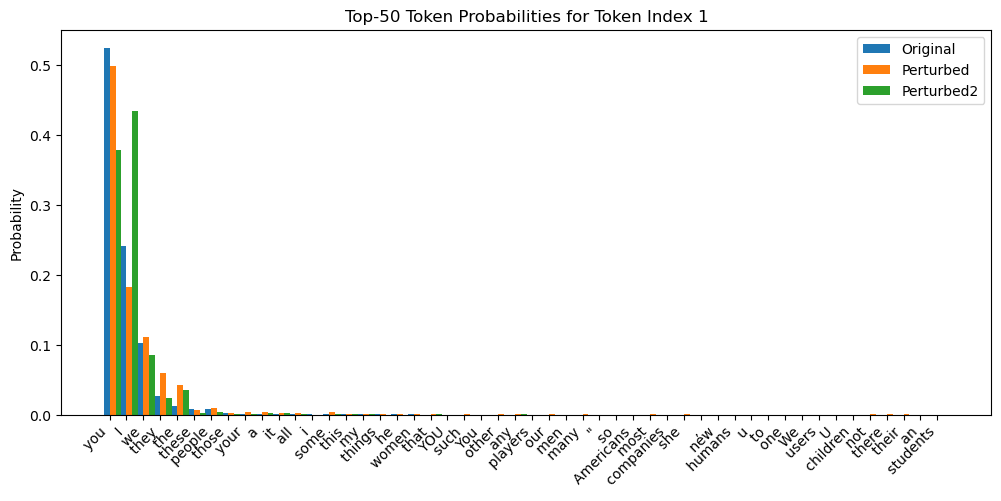

In [55]:
original_tokens = [tokenizer.decode([i]) for i in top_k_indices]

x = np.arange(top_k)  # x-axis: token rank
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, original_topk, width, label='Original')
plt.bar(x + width/2, perturbed_topk, width, label='Perturbed')
plt.bar(x + width*1.5, perturbed_topk2, width, label='Perturbed2')
plt.xticks(x, original_tokens, rotation=45, ha='right')
plt.ylabel("Probability")
plt.title(f"Top-{top_k} Token Probabilities for Token Index {token_idx}")
plt.legend()
plt.show()

### Distribution of logits on entire space

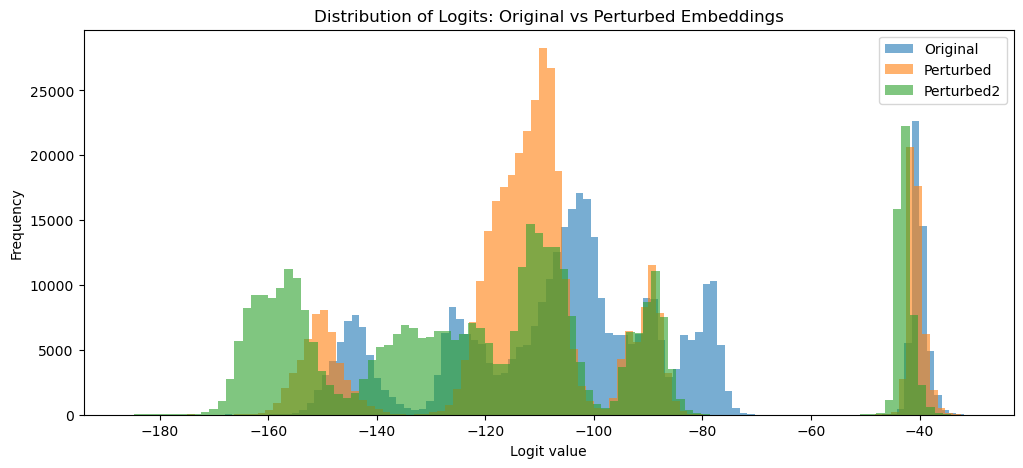

In [56]:
original_logits_flat = original_logits.logits.detach().cpu().numpy().flatten()
perturbed_logits_flat = perturbed_logits.logits.detach().cpu().numpy().flatten()
perturbed_logits_flat2 = perturbed_logits2.logits.detach().cpu().numpy().flatten()

plt.figure(figsize=(12,5))
plt.hist(original_logits_flat, bins=100, alpha=0.6, label='Original')
plt.hist(perturbed_logits_flat, bins=100, alpha=0.6, label='Perturbed')
plt.hist(perturbed_logits_flat2, bins=100, alpha=0.6, label='Perturbed2')
plt.xlabel("Logit value")
plt.ylabel("Frequency")
plt.title("Distribution of Logits: Original vs Perturbed Embeddings")
plt.legend()
plt.show()

### Sparcity of Probabilities

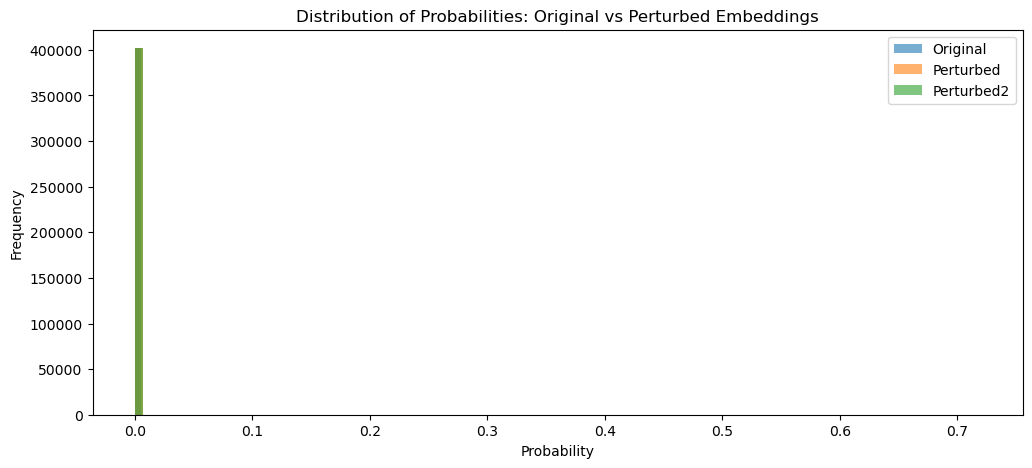

In [ ]:
original_probs_flat = original_probs.detach().cpu().numpy().flatten()
perturbed_probs_flat = perturbed_probs.detach().cpu().numpy().flatten()
perturbed_probs_flat2 = perturbed_probs2.detach().cpu().numpy().flatten()

plt.figure(figsize=(12,5))
plt.hist(original_probs_flat, bins=100, alpha=0.6, label='Original')
plt.hist(perturbed_probs_flat, bins=100, alpha=0.6, label='Perturbed')
plt.hist(perturbed_probs_flat2, bins=100, alpha=0.6, label='Perturbed2')
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities: Original vs Perturbed Embeddings")
plt.legend()
plt.show()